# Sprint 14 Project: Machine Learning for Texts

## Introduction

### Project Description

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

### Project Instructions

1. Load the data.
2. Preprocess the data, if required.
3. Conduct an EDA and make your conclusion on the class imbalance.
4. Preprocess the data for modeling.
5. Train at least three different models for the given train dataset.
6. Test the models for the given test dataset.
7. Compose a few of your own reviews and classify them with all the models.
8. Check for differences between the testing results of models in the above two points. Try to explain them.
9. Present your findings.

### Project Notes

- We suggest trying classification models based on logistic regression and gradient boosting, but feel free to try other methods.
- You don't have to use BERT for the project because it is very demanding for computational power and will be very slow on the CPU for the complete dataset.

### Data Description

The data is stored in the `imdb_reviews.tsv` file.

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Here's the description of the selected fields:

- `review`: the review text
- `pos`: the target, '0' for negative and '1' for positive
- `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly

*There are other fields in the dataset. Feel free to explore them if you'd like.*

## Initialization

### Import Libraries and Configurations for Analysis

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

### View Sample of Dataset

In [5]:
# Print head of the data frame
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


### Explore Dataset

In [6]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(df_reviews.isna().sum())
print()


# Check values for each column
print('Describe Dataframe')
print(df_reviews.describe())
print()

# Check data types
print('Check Data Types')
print(df_reviews.info())
print()

# Check for Duplicates
print('Count of Duplicated Rows')
print(df_reviews.duplicated().sum())
print()

Check for Missing Values
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Describe Dataframe
         start_year      is_adult  average_rating         votes        rating  \
count  47331.000000  47331.000000    47329.000000  4.732900e+04  47331.000000   
mean    1989.631235      0.001732        5.998278  2.556292e+04      5.484608   
std       19.600364      0.041587        1.494289  8.367004e+04      3.473109   
min     1894.000000      0.000000        1.400000  9.000000e+00      1.000000   
25%     1982.000000      0.000000        5.100000  8.270000e+02      2.000000   
50%     1998.000000      0.000000        6.300000  3.197000e+03      4.000000   
75%     2004.00000

### Data Exploration Findings

- Reviews are for movies from the years 1894 to 2010.
- There are about 47,000 reviews in the dataset.
- Ratings are likely on a scale of 1 to 10 (since the min and max are 1.4 and 9.7).

- There are 2 rows with missing `average_rating` and `votes` fields. I will remove these in the next cell.
- There are no duplicate rows.

### Removal of Missing Values

In [7]:
# Dropping these two rows from df_reviews because data is missing for both votes and average_rating
df_reviews = df_reviews.dropna()

# Check again for rows with missing data
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## Exploratory Data Analysis

### Number of Movies and Reviews Over Time

Let's check the number of movies and reviews over years.

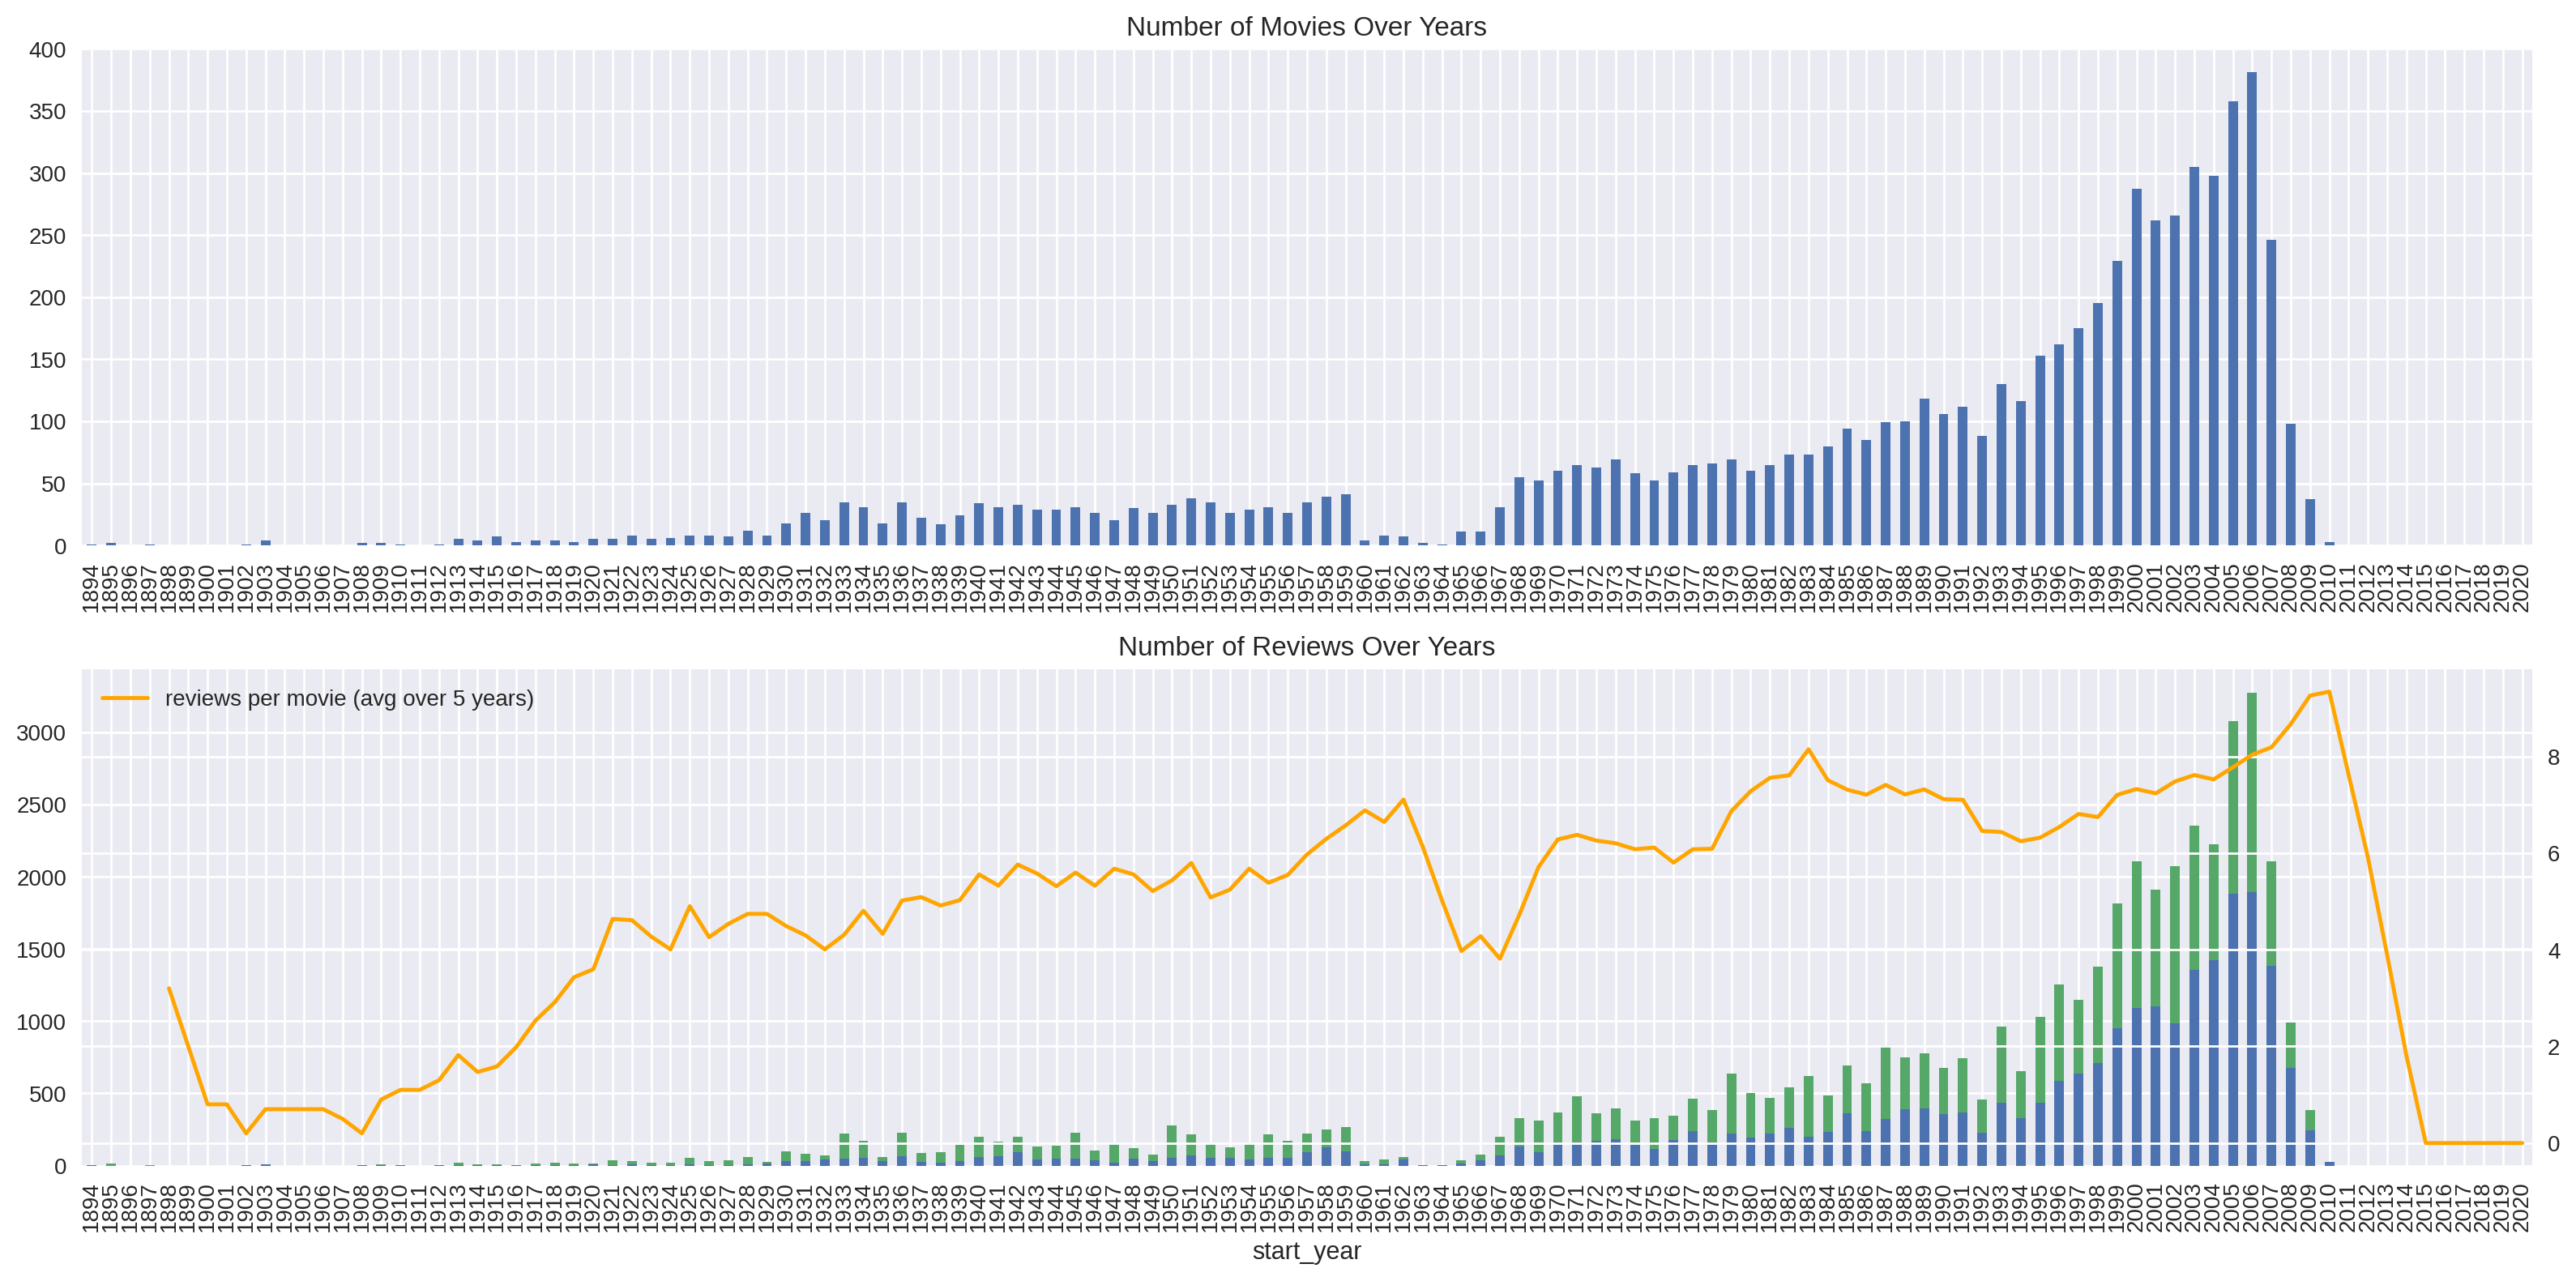

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

**Observations:** Over time, both the number of movies and reviews have increased. The majority of movies/reviews are from the last 20 years of the dataset (1990-2010).

### Number of Reviews per Movie

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

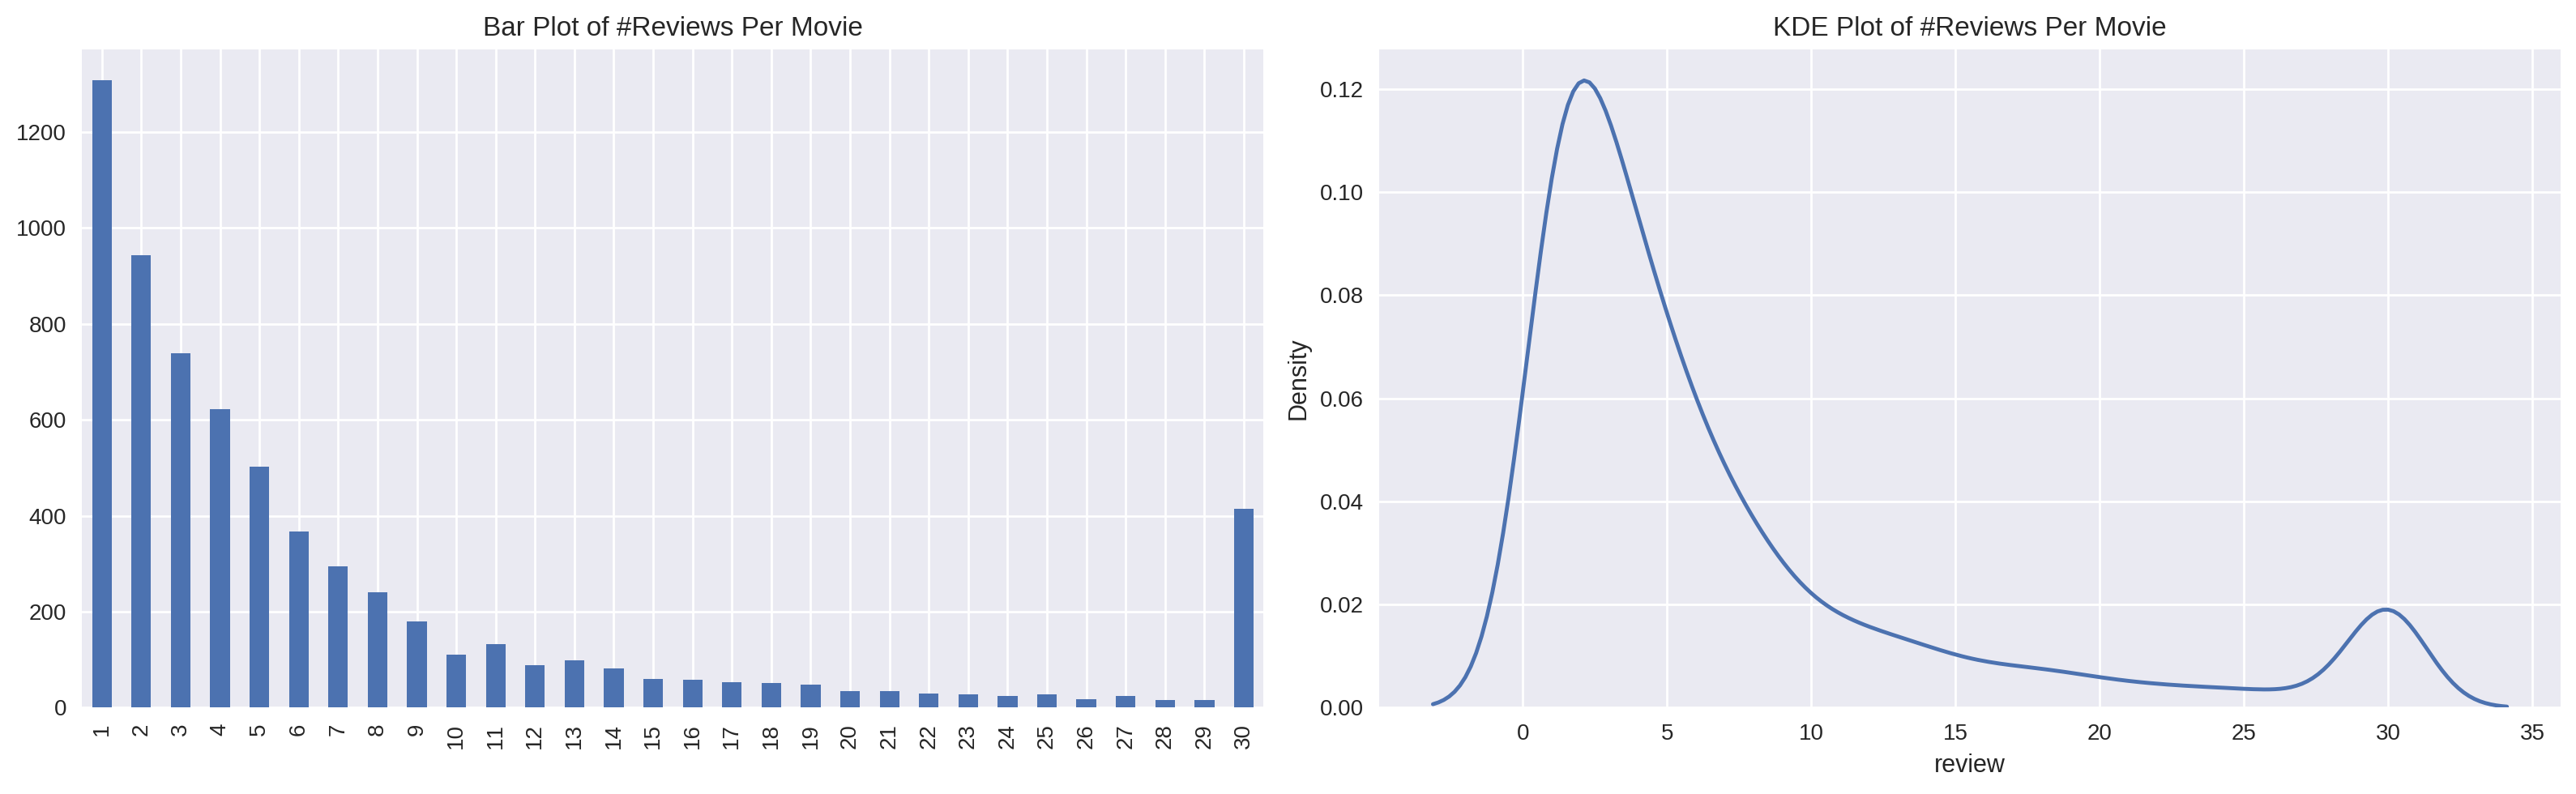

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**Observations:** Most movies only have 1 review, while the mean appears to be approximately 3. Therefore, the data is skewed to the right.

### Review Sentiment and Rating Distribution

Now, let's take a look at the sentiment of reviews (positive or negative) as well as the distribution of ratings (1-10).

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

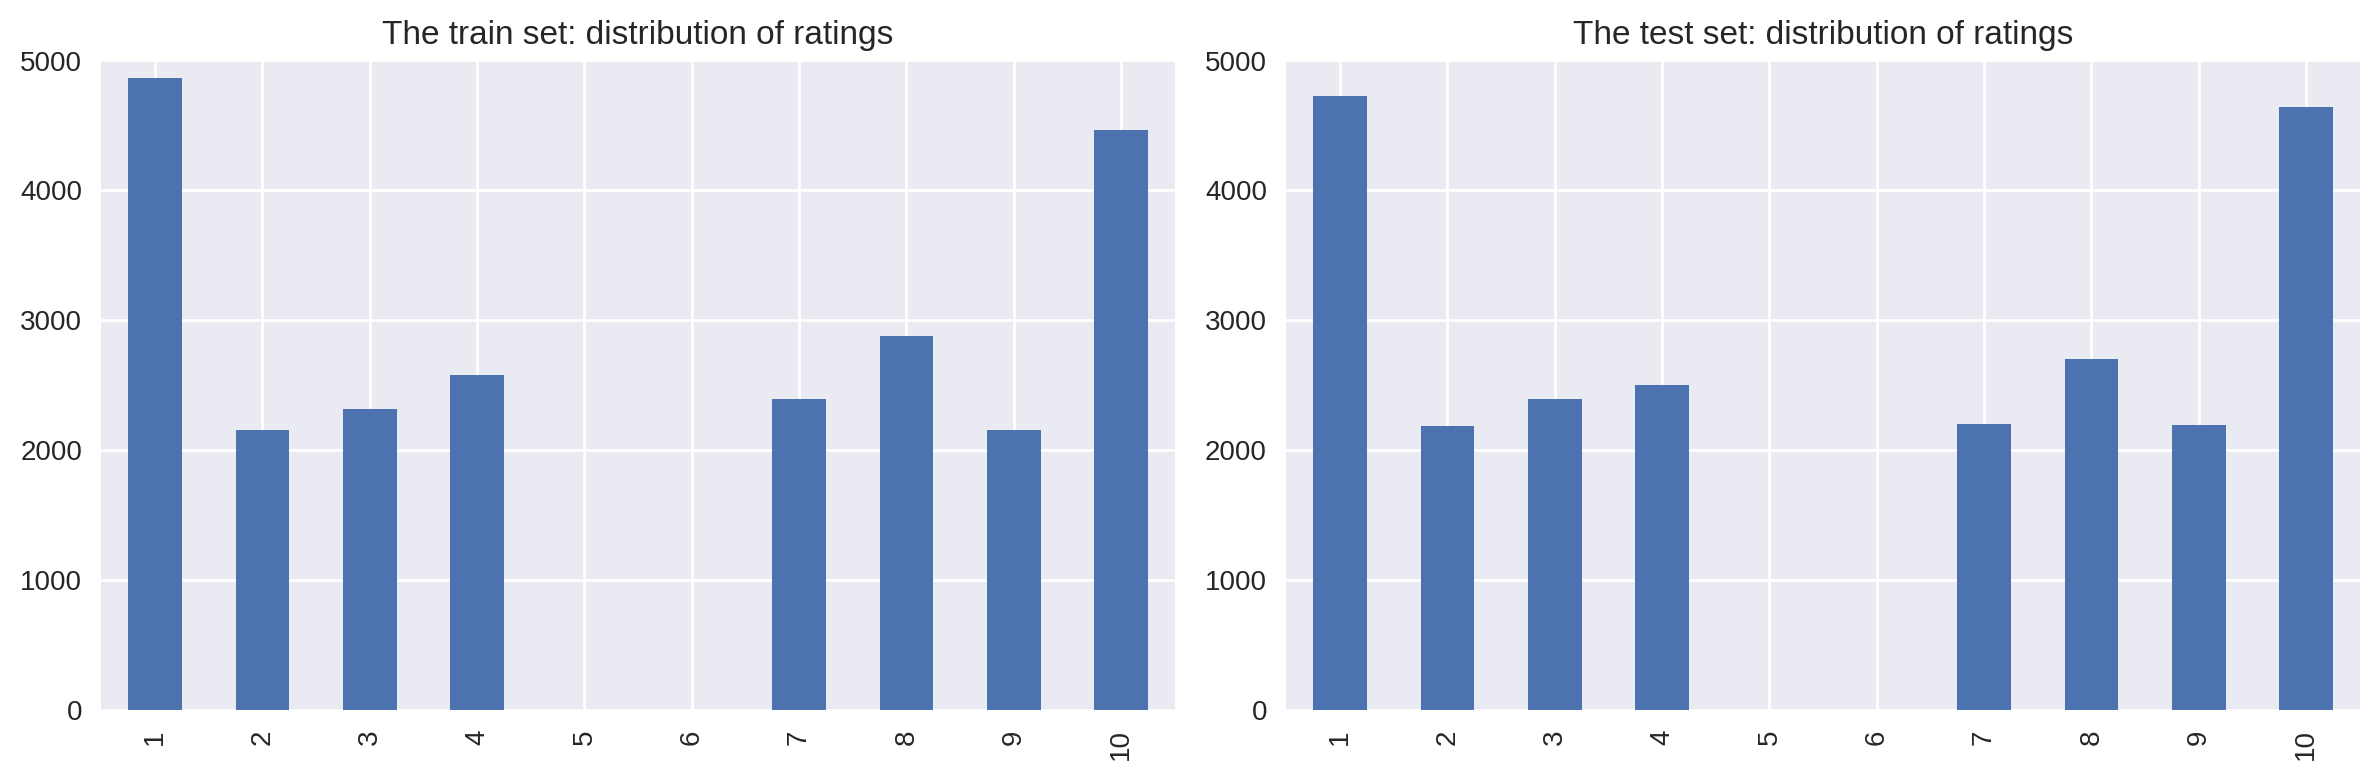

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

**Observations:** Negative and positive reviews are nearly equal in the overall dataset. Negative ratings (1-4) and positive ratings (7-10) are also nearly equal in the split training and test datasets.

### Distribution of Negative and Positive Reviews Over Time

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


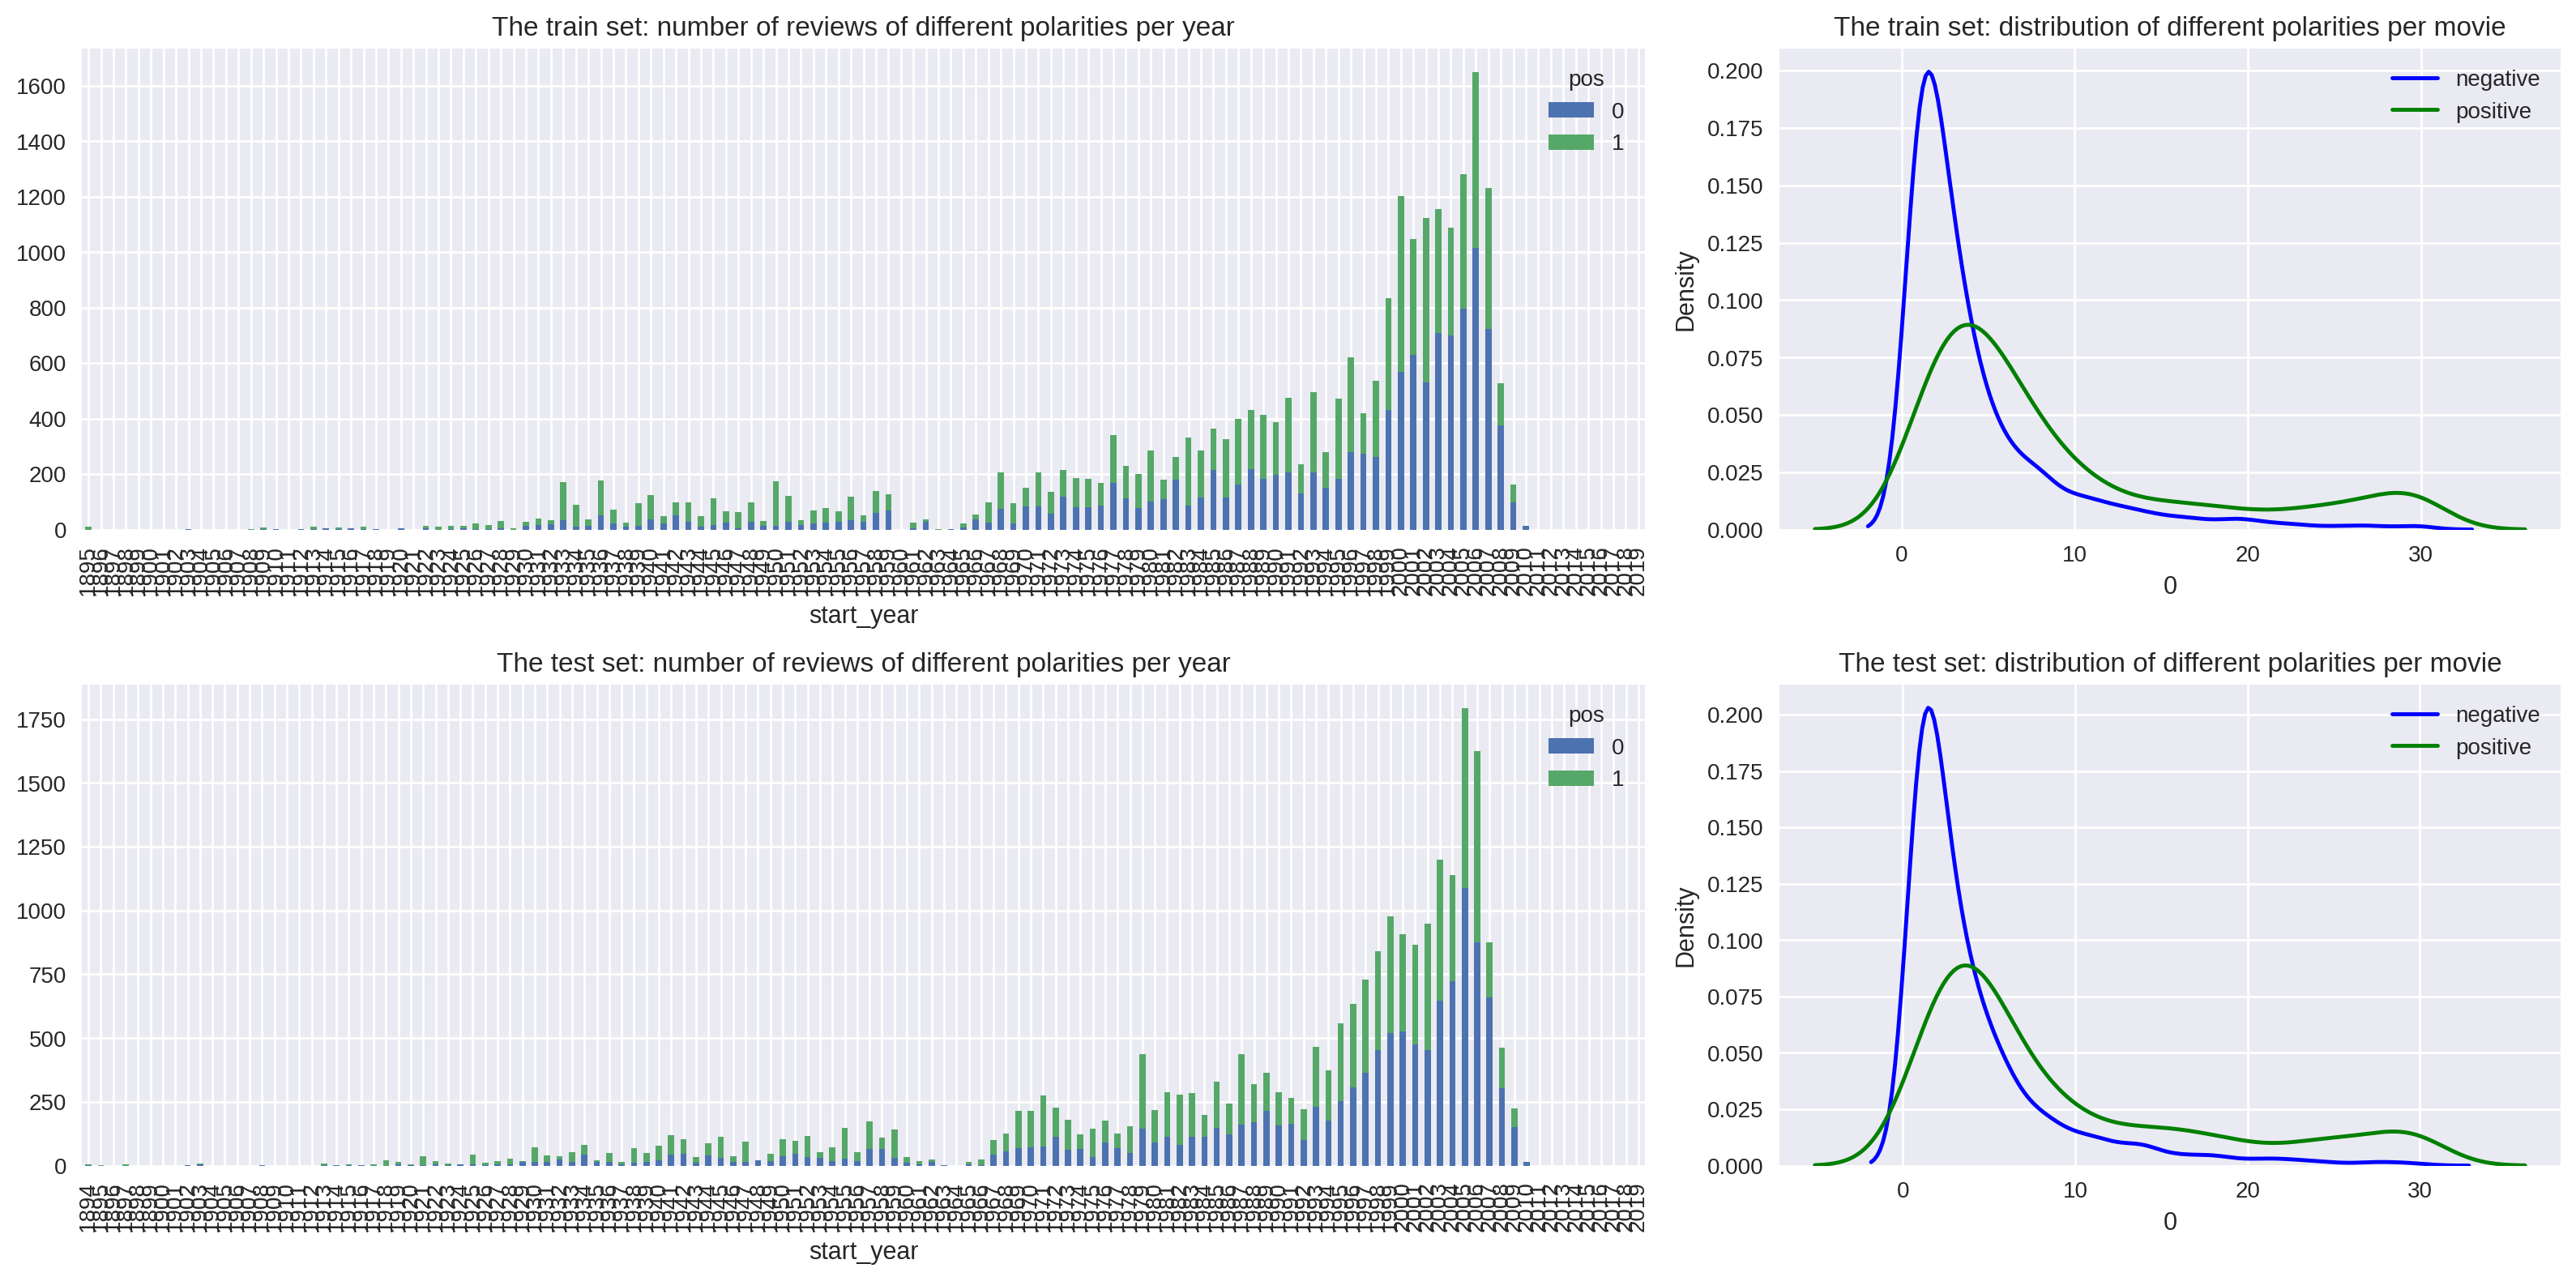

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Observations:** The distribution of each sentiment polarity (positive vs. negative) are similr across the test and training sets.

### Exploratory Data Analysis Summary

- Over time, both the number of movies and reviews have increased. The majority of the movies and reviews are from the last 20-30 years of data, ending in 2010.
- Most movies only have 1 review, but the mean number of reviews per movie is approximately 3. Therefore, the distribution is skewed to the right.
- In the complete dataset, the ratio of positive (1) to negative (0) reviews is nearly a 50-50 split.
- In the training and test sets, positive (1-4) and negative (7-10) ratings are nearly evenly split.
- Ratings of 1 are more common than 2-4, and ratings of 10 are more common than  7-9, likely because raters tend to pick an extreme.
- Ratings of 5 and 6 appear to be considered neutral rather than positive or negative.
- Review sentiment polarity (positive vs. negative) per year is similar across the test and training sets.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
# Import regular expressions module
import re

# Tokenize and normalize - create function to keep only letters and convert all strings to lowercase
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^A-Za-z]', ' ', x.lower()).split()))

# Print single normalized review as a check
df_reviews['review_norm'][0]

'the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that s not what i got out of it i didn t get anything in the first half there s a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there s always an irritating sound in the background whether it s a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of parts that are laughably bad too like the bad guys chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen times i really hated this movie'

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Create features - drop pos column
features_train = df_reviews_train.drop(['pos'], axis=1)
features_test = df_reviews_test.drop(['pos'], axis=1)

# Create targets - only pos column
target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

# Print shapes
print(df_reviews_train.shape)
print(df_reviews_test.shape)
print()
print(features_train.shape)
print(features_test.shape)
print()
print(target_train.shape)
print(target_test.shape)

(23796, 18)
(23533, 18)

(23796, 17)
(23533, 17)

(23796,)
(23533,)


## Modeling and Evaluation

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
CPU times: user 393 ms, sys: 2.86 ms, total: 396 ms
Wall time: 445 ms


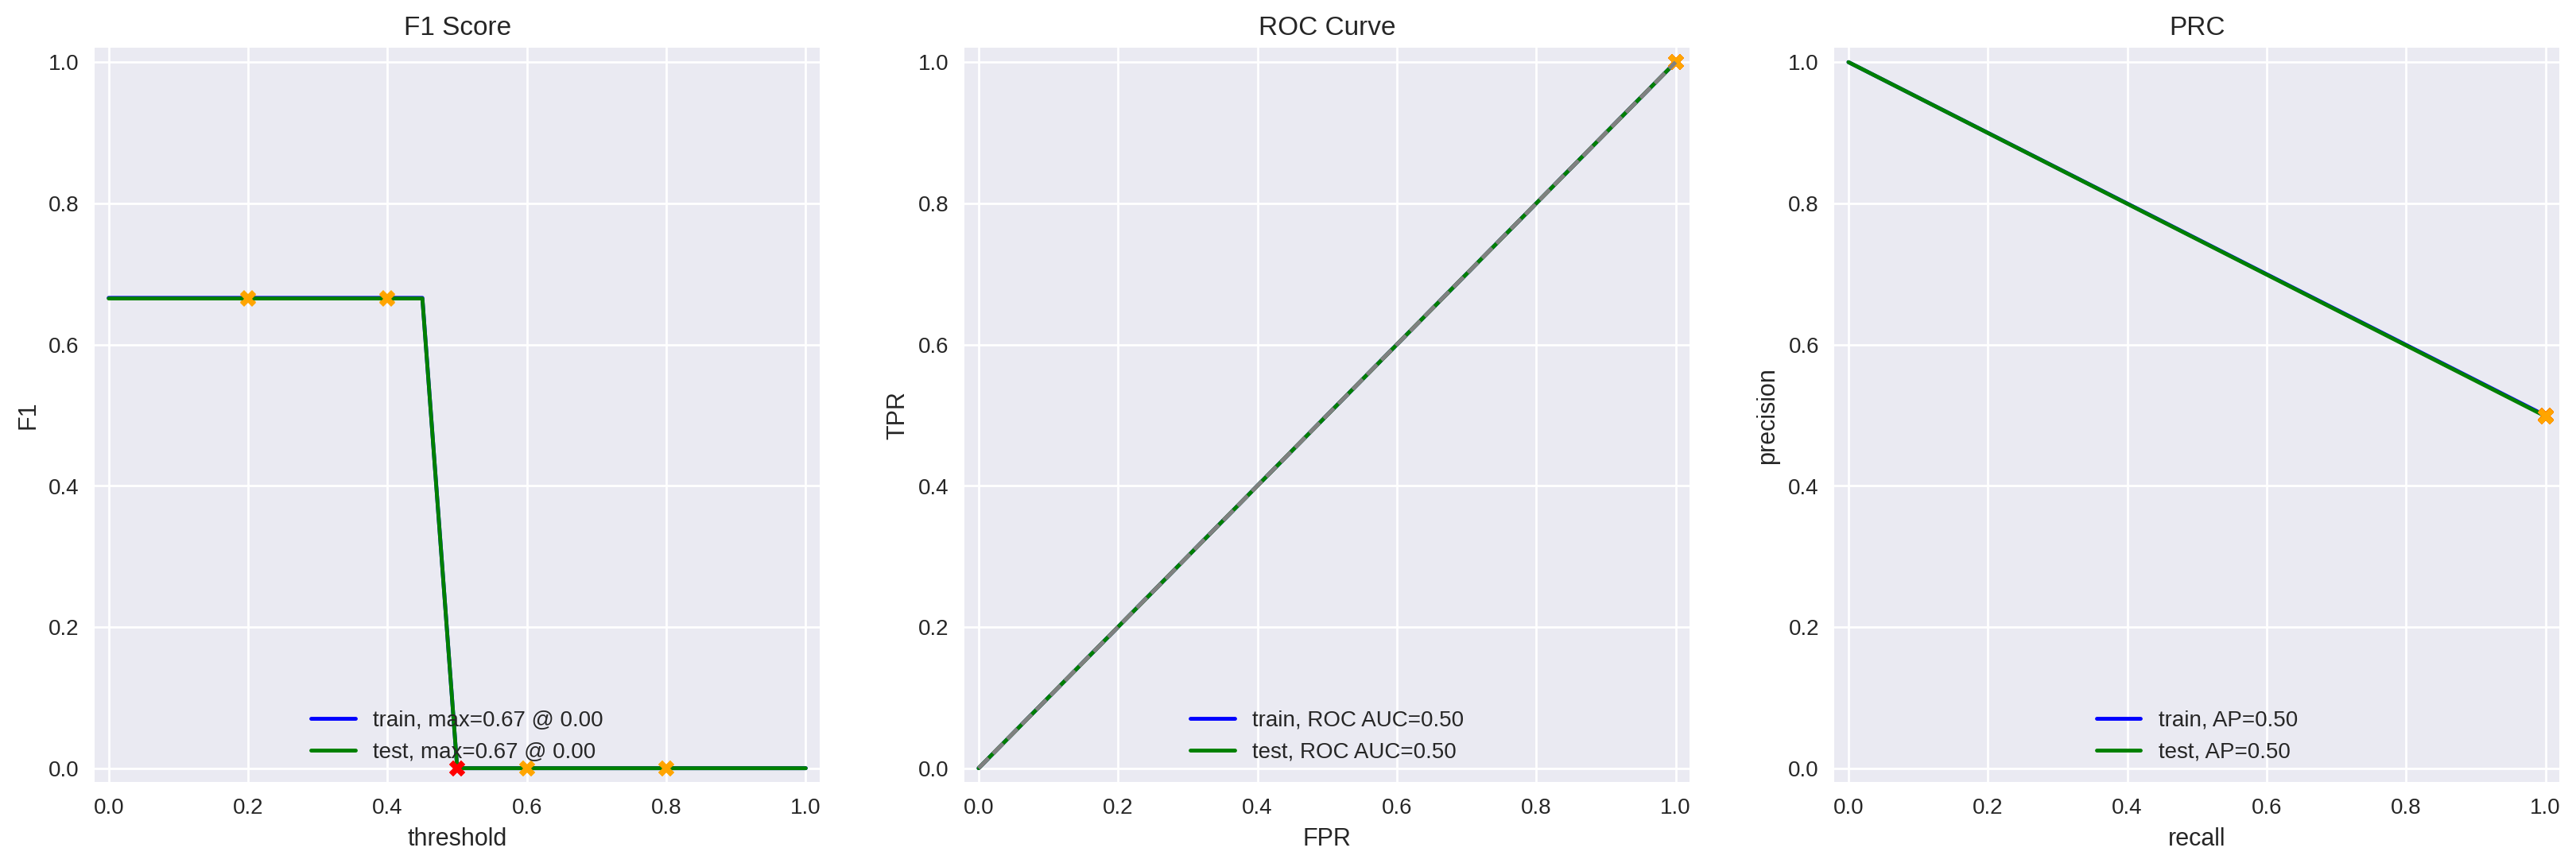

In [16]:
%%time

# Import DummyClassifier - simulates random chance, in this case a 50%/50% split of review sentiment
from sklearn.dummy import DummyClassifier

# Initiate DummyClassifier
model_0 = DummyClassifier()

# Fit model to training data
model_0.fit(features_train, target_train)

# Evaluate model
evaluate_model(model_0, features_train, target_train, features_test, target_test)

**Observations:** This will serve as a baseline for comparison - an accuracy score of 50% is not a serious model.

### Model 1 - NLTK, TF-IDF, LR

In [17]:
# Import Natural Language Toolkit
import nltk

# Convert a collection of raw documents into a matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Import list of stopwords to remove
from nltk.corpus import stopwords

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: user 8.4 s, sys: 644 ms, total: 9.04 s
Wall time: 9.42 s


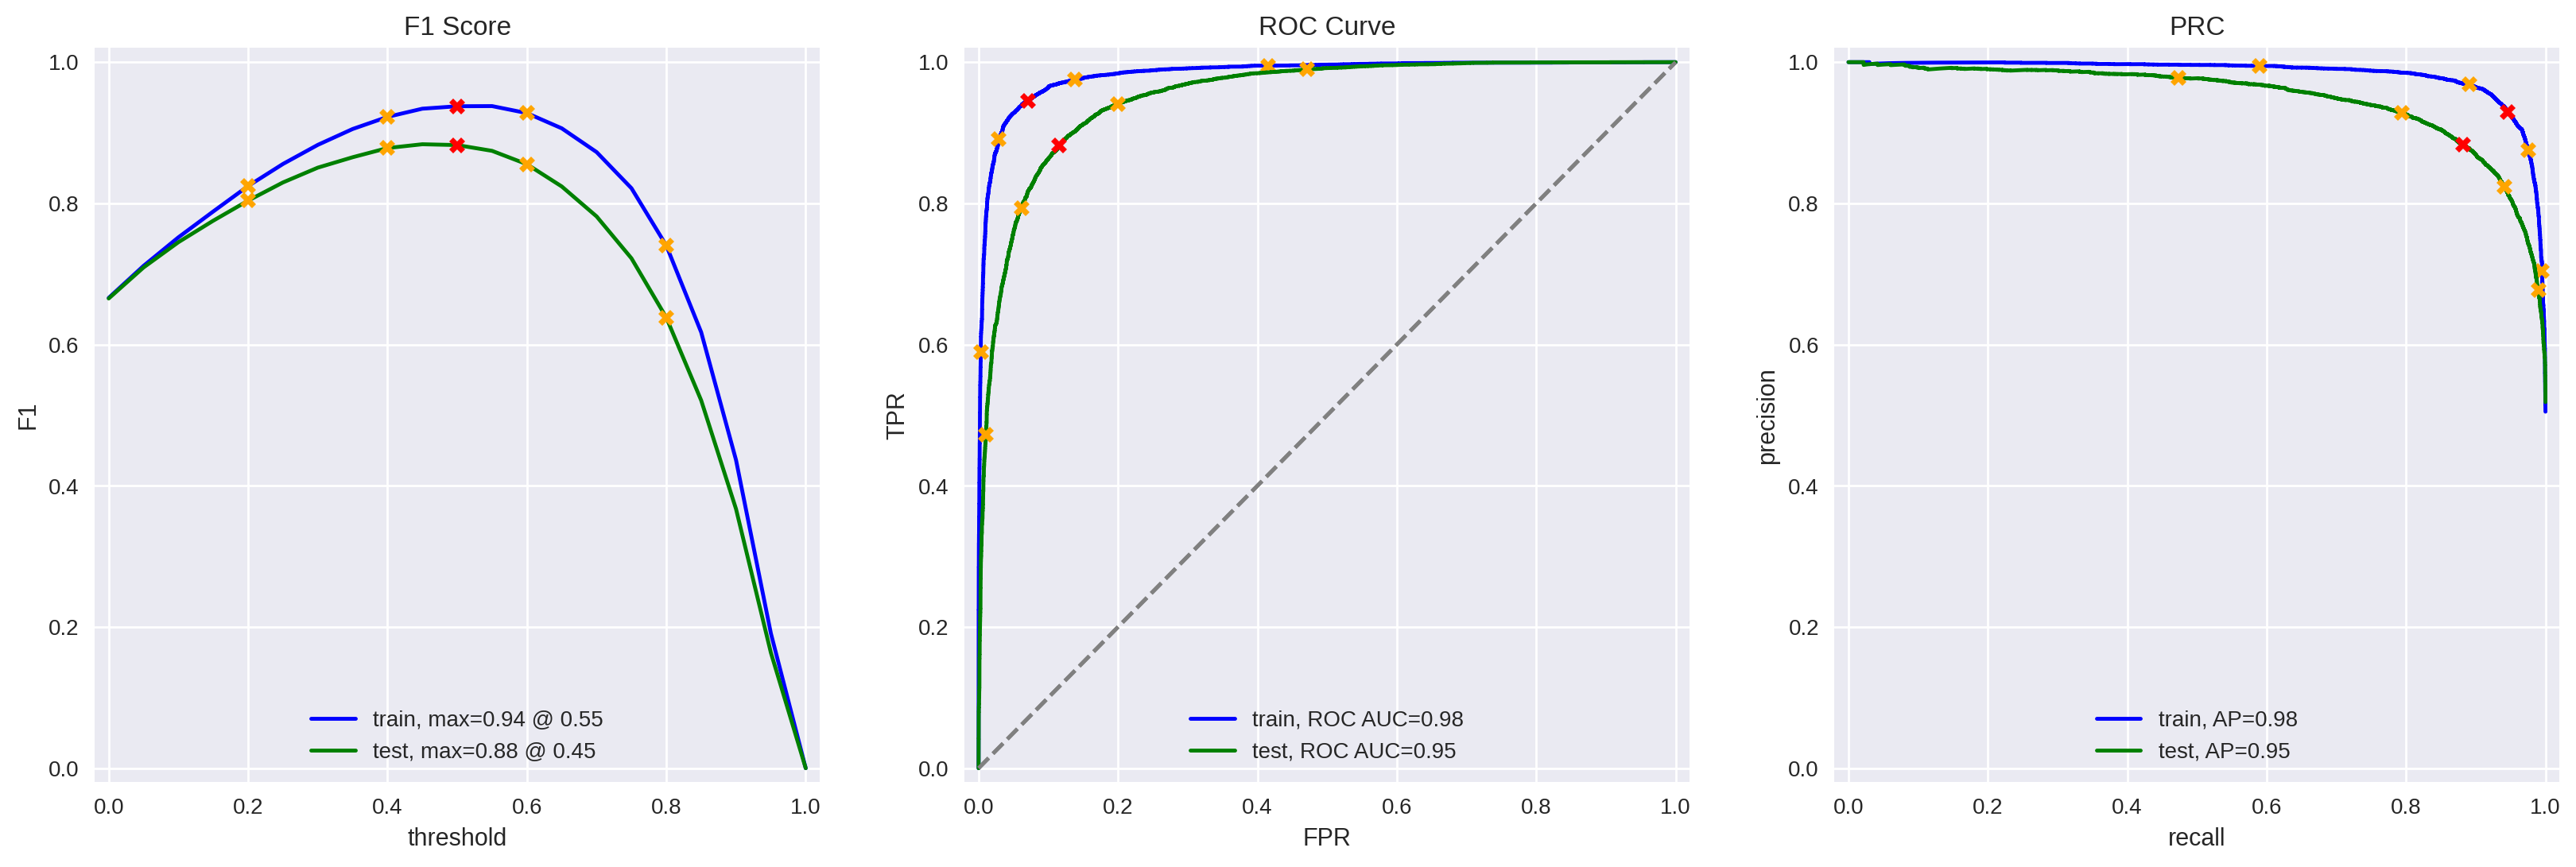

In [18]:
%%time

# Store normalized reviews to new corpus variables for training and test sets
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

# Create list of stopwords which will be removed by TfidfVectorizer
stop_words = stopwords.words('english')

# Convert a collection of raw documents to a matrix of TF-IDF features and provide stop words
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

# Fit TfidfVectorizer to training corpus and vectorize/transform it 
features_train_1 =  tfidf_vectorizer_1.fit_transform(corpus_train)

# Instantiate LogisticRegression model
model_1 = LogisticRegression(solver= 'liblinear', random_state = 1234)

# Fit LR model to train vectorized features and train target
model_1.fit(features_train_1, target_train)

# Vectorize test corpus 
features_test_1 = tfidf_vectorizer_1.transform(corpus_test)

# Predict test targets using transformed test corpus
predictions = model_1.predict(features_test_1)

# Evaluate model using evaluation procedure
evaluate_model(model_1, features_train_1, target_train, features_test_1, target_test)

**Observations:** This model is pretty accurate - 94% on training set and 88% on test set.

### Model 2 - spaCy, TF-IDF, LR

*Note: Lemmatization takes several minutes*

In [19]:
# SpaCy is a library for advanced natural language processing
import spacy

# Load small-size English-language model, disable some pipeline components
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
# Create a function for lemmatization (return words to their base forms)
def text_preprocessing_2(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

*Screenshot of lemmatization code (cell 26) since it takes several min to run:*
![](Lemmatization.png)

In [21]:
%%time

# # Lemmatize df_reviews['review_norm']
# df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_2) 

CPU times: user 9min 58s, sys: 320 ms, total: 9min 59s
Wall time: 10min 7s


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: user 7.27 s, sys: 1.42 s, total: 8.69 s
Wall time: 8.71 s


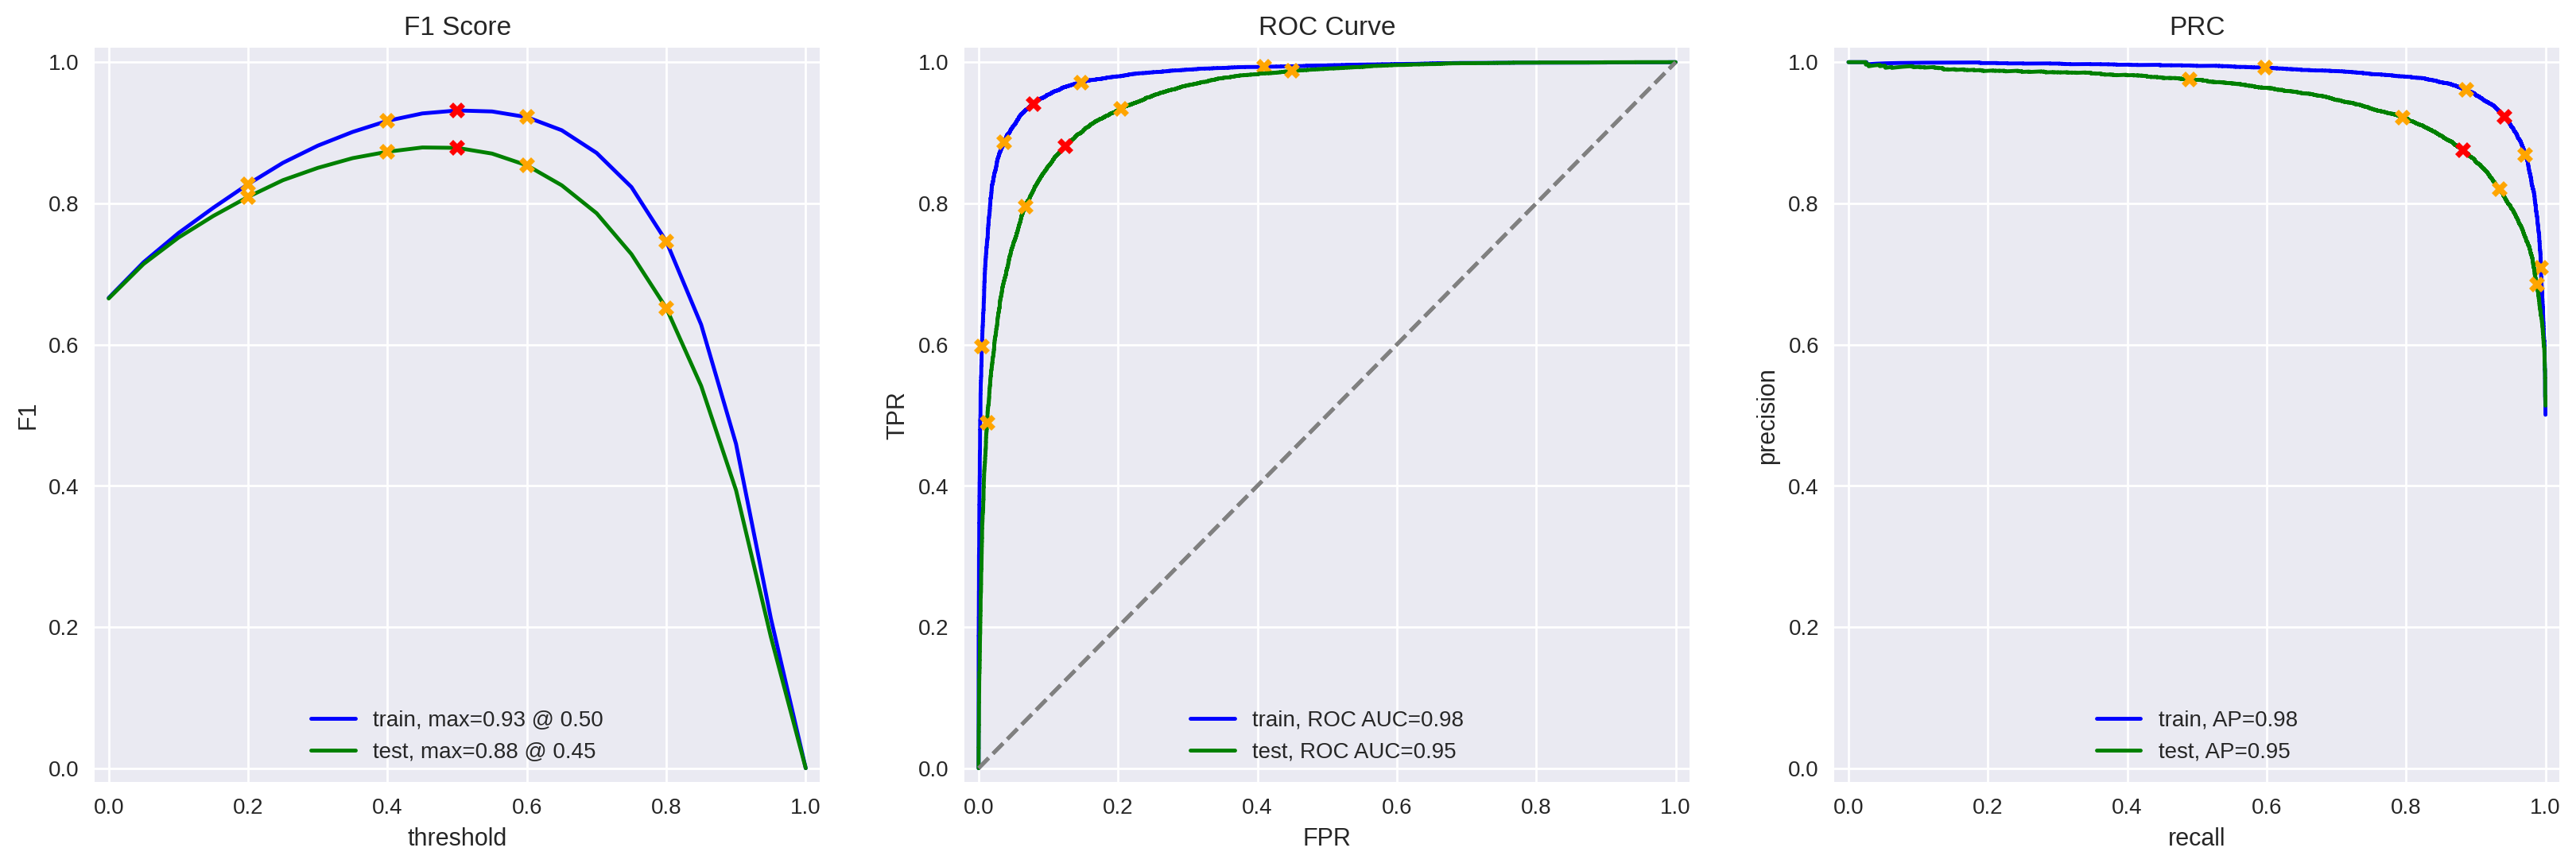

In [22]:
%%time

# Create copy of df_reviews and split into train and test sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Store test and train features to new variable
corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']

# Create list of stopwords which will be removed by TfidfVectorizer
stop_words = stopwords.words('english')

# Convert a collection of raw documents to a matrix of TF-IDF features. Provide stop words
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

# Fit tfidf_vectorizer to training corpus and vectorize/transform it 
# Convert the datatype object to unicode string - otherwise I get an error
features_train_2 =  tfidf_vectorizer_2.fit_transform(corpus_train.astype('U'))

# Instantiate LogisticRegression model
model_2 = LogisticRegression(solver= 'liblinear', random_state = 1234)

# Fit LR model to train vectorized features and train target
model_2.fit(features_train_2, target_train)

# Vectorize test corpus 
# Convert the datatype object to unicode string - otherwise I get an error
features_test_2 =  tfidf_vectorizer_2.transform(corpus_test.astype('U'))

# Predict test targets using transformed test corpus
predictions = model_2.predict(features_test_2)

# Evaluate model using evaluation procedure
evaluate_model(model_2, features_train_2, target_train, features_test_2, target_test)

**Observations:** This model is about as accurate as the NTLK version (Model 1).

### Model 3 - spaCy, TF-IDF, LGBMClassifier

In [23]:
# Light Gradient Boosting Machine Classifier
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94
CPU times: user 54 s, sys: 213 ms, total: 54.2 s
Wall time: 54.3 s


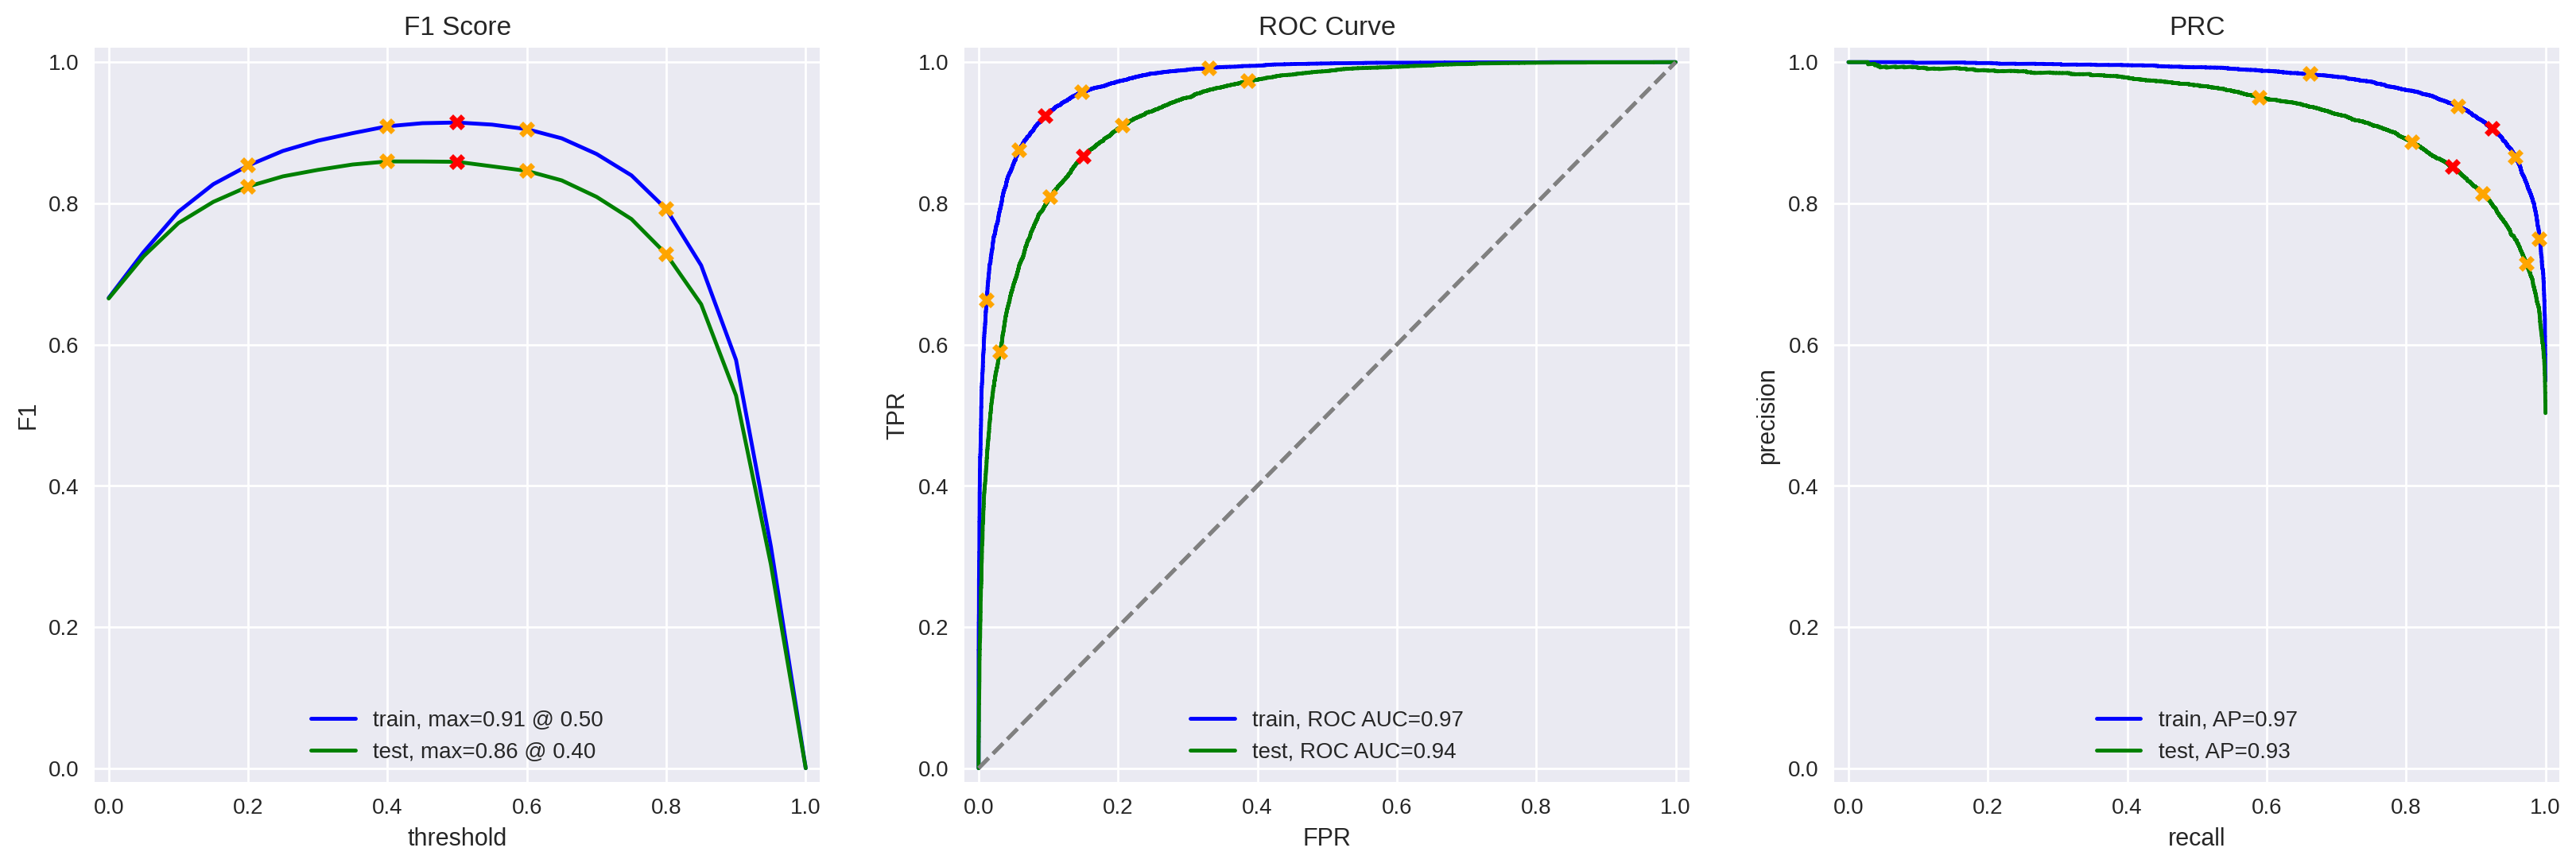

In [24]:
%%time

# Store test and train features to new variable
corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']

# Create list of stopwords which will be removed by TfidfVectorizer
stop_words = stopwords.words('english')

# Convert a collection of raw documents to a matrix of TF-IDF features. Provide stop words
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

# Fit tfidf_vectorizer to training corpus and vectorize/transform it 
# Convert the datatype object to unicode string - otherwise I get an error
features_train_3 =  tfidf_vectorizer_3.fit_transform(corpus_train)

# Instantiate LGBMClassifier model
model_3 = LGBMClassifier(random_state = 1234)

# Fit LR model to train vectorized features and train target
model_3.fit(features_train_3, target_train)

# Vectorize test corpus 
features_test_3 = tfidf_vectorizer_3.transform(corpus_test)

# Predcit test targets using transformed test corpus
predictions = model_3.predict(features_test_3)

# Evaluate model using evaluation procedure
evaluate_model(model_3, features_train_3, target_train, features_test_3, target_test)

**Observations:** This model is similar to the others, possibly slightly less accurate.

###  Model 4 - BERT

*I will not be using BERT for this project because it is very demanding for computational power and will be very slow on the CPU for the complete dataset. I've commented out all cells in this notebook related to BERT.*

In [25]:
# import torch
# import transformers

In [26]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [27]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#    ids_list = []
#    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
#    if force_device is not None:
#        device = torch.device(force_device)
#    else:
#        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#    model.to(device)
#    if not disable_progress_bar:
#        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

#    embeddings = []

#    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
#        with torch.no_grad():            
#            model.eval()
#            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#    return np.concatenate(embeddings)

In [28]:
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [29]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [30]:
# # if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

### Summary of Model Selection and Performance

#### On Training Set:

| Model # | Model Name | Accuracy | F1 Score | APS | AUC-ROC |
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| 0 | Constant | 0.50  | 0.00  | 0.50  | 0.50  |
| 1 | NLTK, TF-IDF, LR  | 0.94  | 0.94  | 0.98  | 0.98  |
| 2 | spaCy, TF-IDF, LR  | 0.93  | 0.93  | 0.98  | 0.98  |
| 3 | spaCy, TF-IDF, LGBMClassifier | 0.91  | 0.91 | 0.97 | 0.97  |

#### On Test Set:

| Model # | Model Name | Accuracy | F1 Score | APS | AUC-ROC |
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| 0 | Constant | 0.50  | 0.00  | 0.50  | 0.50  |
| 1 | NLTK, TF-IDF, LR  | 0.88  | 0.88  | 0.95  | 0.95  |
| 2 | spaCy, TF-IDF, LR  | 0.88  | 0.88  | 0.95  | 0.95  |
| 3 | spaCy, TF-IDF, LGBMClassifier | 0.86  | 0.86  | 0.93  | 0.94 |

#### Training and Testing CPU Times:

| Model # | Model Name | CPU Time (s) |
|:----------:|:----------:|:----------:|
| 0 | Constant | 0.26  |
| 1 | NLTK, TF-IDF, LR  | 6.07  |
| 2 | spaCy, TF-IDF, LR  | 5.97  |
| 3 | spaCy, TF-IDF, LGBMClassifier | 41.3  |

## My Reviews

In this section, I composed a few of my own reviews (*Note: I used the reviews provided*) and classified them with the models used in the previous section. *As above, the BERT section will be commented out.*

In [36]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^A-Za-z]', ' ', x.lower()).split()))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1 - NLTK, TF-IDF, LR

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 2 - spaCy, TF-IDF, LR

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3 - spaCy, TF-IDF, LGBMClassifier

In [39]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.37:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.34:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.65:  i didn t expect the reboot to be so good writers really cared about the source material
0.70:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.38:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4 - BERT
*Not used*

In [ ]:
# texts = my_reviews['review_norm']

# my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusion

### Review of Objective

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews with an F1 score of at least 0.85.

### Final Observations

Please refer to the tables at the end of Section 8 for the following observations:
- All models dramatically outperform the constant baseline model (50%/50% chance)
- Models 1, 2, and 3 all produce F1 scores greater than 0.85. 
- Models using LogisticRegression produce the highest F1 scores (0.88 with both NLTK and spaCy).
- NLTK is dramatically faster than spaCy for text preprocessing (under 12 seconds vs over 7 minutes).

### Recommendation

Overall, I recommend a **model using NLTK, TF-IDF, and LR** for Film Junky Union to automatically detect negative reviews in an accurate and fast manner.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions